# Cosine Similarity Analysis of Hashtag Communities

## Overview
This notebook performs an in-depth analysis of hashtag communities across various networks using cosine similarity. The goal is to evaluate the similarity of hashtags within and across communities, visualize the distributions, and identify patterns in user interactions.


## Steps
1. **Community Detection**:
   - Load pre-processed network data from pickled files.
   - Use the Leiden algorithm to partition the networks into communities.

2. **Filtering Communities**:
   - Identify and retain the largest communities (e.g., top 80% by size or a fixed number like 27).
   - Filter the networks to include only nodes from the selected communities.

3. **Cosine Similarity Computation**:
   - For each community, compute cosine similarity between pairs of hashtags using pre-trained embeddings from the `SentenceTransformer` model.
   - Separate similarity computations for:
     - **Within-community edges**: Hashtag pairs within the same community.
     - **Across-community edges**: Hashtag pairs from different communities.

4. **Visualization**:
   - Plot distributions of community sizes before and after filtering.
   - Visualize cosine similarity distributions using histograms, KDE plots, and ridgeline plots for both within-community and across-community pairs.

5. **Statistical Analysis**:
   - Compute average cosine similarity for each network and compare within-community vs. across-community similarities.
   - Summarize results and connect findings to the nature of user interactions in each network.


## Key Features
- **Networks Analyzed**:
  - Co-occurrence network
  - Likes network
  - Follower network
  - Duet/Stitch network

- **Algorithms Used**:
  - Leiden algorithm for community detection.
  - Cosine similarity for hashtag embedding comparison.

- **Libraries**:
  - `igraph` and `leidenalg` for graph processing.
  - `SentenceTransformer` for embedding generation.
  - `matplotlib` and `seaborn` for visualization.
  - `pandas` for data manipulation.

## Outputs
- Filtered networks and their corresponding communities.
- Cosine similarity distributions for within-community and across-community pairs.
- Visualizations of community size distributions and similarity metrics.
- Saved edge lists for further analysis.

In [ ]:
from sentence_transformers import SentenceTransformer
import networkx as nx
import numpy as np
from sklearn.metrics import pairwise, normalized_mutual_info_score as nmi, adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import community as community_louvain
from collections import defaultdict
import pandas as pd
import pickle
import igraph as ig
import leidenalg
import time
import seaborn as sns
import random
import os
import math

In [118]:
network_files = {
    "cooccurrence": "../ready_networks/cooc_filtered.pkl",
    "likes": "../ready_networks/likes_network.pkl",
    "follower": "../ready_networks/follow_filtered.pkl",
    "duet_stitch": "../ready_networks/ds_network.pkl"
}
networks = {name: pickle.load(open(path, 'rb')) for name, path in network_files.items()}

In [127]:
for name, G in networks.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print(f"{name}: {num_nodes} nodes, {num_edges} edges")


cooccurrence: 39905 nodes, 435990 edges
likes: 480 nodes, 9255 edges
follower: 26153 nodes, 334979 edges
duet_stitch: 4195 nodes, 54728 edges


In [ ]:
def nx_to_igraph(G):
    G = G.copy()
    is_directed = nx.is_directed(G)

    # Create igraph Graph
    ig_graph = ig.Graph(directed=is_directed)

    # Add nodes
    ig_graph.add_vertices(list(G.nodes))

    # Add edges
    ig_graph.add_edges(list(G.edges))

    # Transfer weights if they exist
    if nx.get_edge_attributes(G, 'weight'):
        ig_graph.es['weight'] = [G[u][v].get('weight', 1.0) for u, v in G.edges]

    return ig_graph


## Systematic evaluation framework for choosing which algoritm to use for community partition 

In [ ]:
def compute_modularity(G, communities):
    return nx.algorithms.community.quality.modularity(G, communities)

def compute_conductance(G, communities):
    conductances = []
    for community in communities:
        cut_size = nx.cut_size(G, community)
        volume = sum(dict(G.degree(community)).values())
        if volume > 0:
            conductances.append(cut_size / volume)
    return np.mean(conductances) if conductances else None

def partition_to_labels(partition, node_list):
    labels = np.zeros(len(node_list), dtype=int)
    node_to_idx = {node: idx for idx, node in enumerate(node_list)}
    for cid, community in enumerate(partition):
        for node in community:
            labels[node_to_idx[node]] = cid
    return labels

# ----- Main Analysis -----
results = {}

for name, G_nx in networks.items():
    print(f"\n🔍 Analyzing: {name}")
    G_ig = nx_to_igraph(G_nx)
    nodes = list(G_nx.nodes())
    is_directed = G_ig.is_directed()

    # ---- Louvain ----
    louvain_runs = []
    for i in range(5):  # multiple runs for stability
        start = time.time()
        louvain_partition = community_louvain.best_partition(G_nx)
        elapsed = time.time() - start
        comm_dict = defaultdict(list)
        for node, comm in louvain_partition.items():
            comm_dict[comm].append(node)
        communities = list(comm_dict.values())
        modularity = compute_modularity(G_nx, communities)
        conductance = compute_conductance(G_nx, communities)
        labels = partition_to_labels(communities, nodes)
        louvain_runs.append((modularity, conductance, elapsed, labels))

    # ---- Leiden ----
    leiden_runs = []
    for i in range(5):
        start = time.time()
        try:
            if is_directed:
                partition = leidenalg.find_partition(G_ig, leidenalg.CPMVertexPartition)
            else:
                partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
        except Exception as e:
            print(f"⚠️ Leiden failed on {name} ({'directed' if is_directed else 'undirected'}): {e}")
            continue        
        elapsed = time.time() - start
        communities = [G_ig.vs[community]["name"] for community in partition]
        modularity = partition.modularity
        conductance = compute_conductance(G_nx, communities)
        labels = partition_to_labels(communities, nodes)
        leiden_runs.append((modularity, conductance, elapsed, labels))

    # ---- Stability Measures ----
    def compute_stability(run_labels):
        n = len(run_labels)
        nmi_scores = [nmi(run_labels[i], run_labels[j])
                      for i in range(n) for j in range(i+1, n)]
        return np.mean(nmi_scores)

    louvain_mods, louvain_conds, louvain_times, louvain_labels = zip(*louvain_runs)
    leiden_mods, leiden_conds, leiden_times, leiden_labels = zip(*leiden_runs)

    # ---- Ground-truth comparison (if labels exist) ----
    if 'label' in G_nx.nodes[nodes[0]]:
        true_labels = [G_nx.nodes[n]['label'] for n in nodes]
        louvain_nmi = nmi(true_labels, louvain_labels[0])
        louvain_ari = adjusted_rand_score(true_labels, louvain_labels[0])
        leiden_nmi = nmi(true_labels, leiden_labels[0])
        leiden_ari = adjusted_rand_score(true_labels, leiden_labels[0])
    else:
        louvain_nmi = leiden_nmi = louvain_ari = leiden_ari = None

    results[name] = {
        "louvain": {
            "modularity_mean": np.mean(louvain_mods),
            "conductance_mean": np.mean(louvain_conds),
            "runtime_mean": np.mean(louvain_times),
            "stability": compute_stability(louvain_labels),
            "nmi": louvain_nmi,
            "ari": louvain_ari
        },
        "leiden": {
            "modularity_mean": np.mean(leiden_mods),
            "conductance_mean": np.mean(leiden_conds),
            "runtime_mean": np.mean(leiden_times),
            "stability": compute_stability(leiden_labels),
            "nmi": leiden_nmi,
            "ari": leiden_ari
        }
    }

    #summary
    print(f"  Louvain: Mod={results[name]['louvain']['modularity_mean']:.4f}, Cond={results[name]['louvain']['conductance_mean']:.4f}, "
          f"Time={results[name]['louvain']['runtime_mean']:.4f}s, Stability={results[name]['louvain']['stability']:.4f}")
    print(f"  Leiden : Mod={results[name]['leiden']['modularity_mean']:.4f}, Cond={results[name]['leiden']['conductance_mean']:.4f}, "
          f"Time={results[name]['leiden']['runtime_mean']:.4f}s, Stability={results[name]['leiden']['stability']:.4f}")


🔍 Analyzing: cooccurrence
  Louvain: Mod=0.5816, Cond=0.0227, Time=7.3715s, Stability=0.7117
  Leiden : Mod=0.5922, Cond=0.0215, Time=2.2635s, Stability=0.7520

🔍 Analyzing: likes
  Louvain: Mod=0.7991, Cond=0.0343, Time=0.0270s, Stability=0.9983
  Leiden : Mod=0.7958, Cond=0.0280, Time=0.0195s, Stability=1.0000

🔍 Analyzing: follower


TypeError: Bad graph type, use only non directed graph

In [129]:
# Initialize communities as an empty dictionary
communities = {}
for name, nx_graph in networks.items():
    ig_graph = nx_to_igraph(nx_graph)
    partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
    communities[name] = partition
    print(f"{name}: {len(partition)} communities detected.")

# partition: list-like object where each entry is a list of node IDs (integers) forming a community.


cooccurrence: 579 communities detected.
likes: 14 communities detected.
follower: 22 communities detected.
duet_stitch: 23 communities detected.


### Visualising the size distribution

/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/4155748222.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)  # Optional: hide empty legend
/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/4155748222.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)  # Optional: hide empty legend
/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/4155748222.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)  # Optional: hide empty legend
/var/folders/c1/phfhvpvx33z0wfs1rywcs

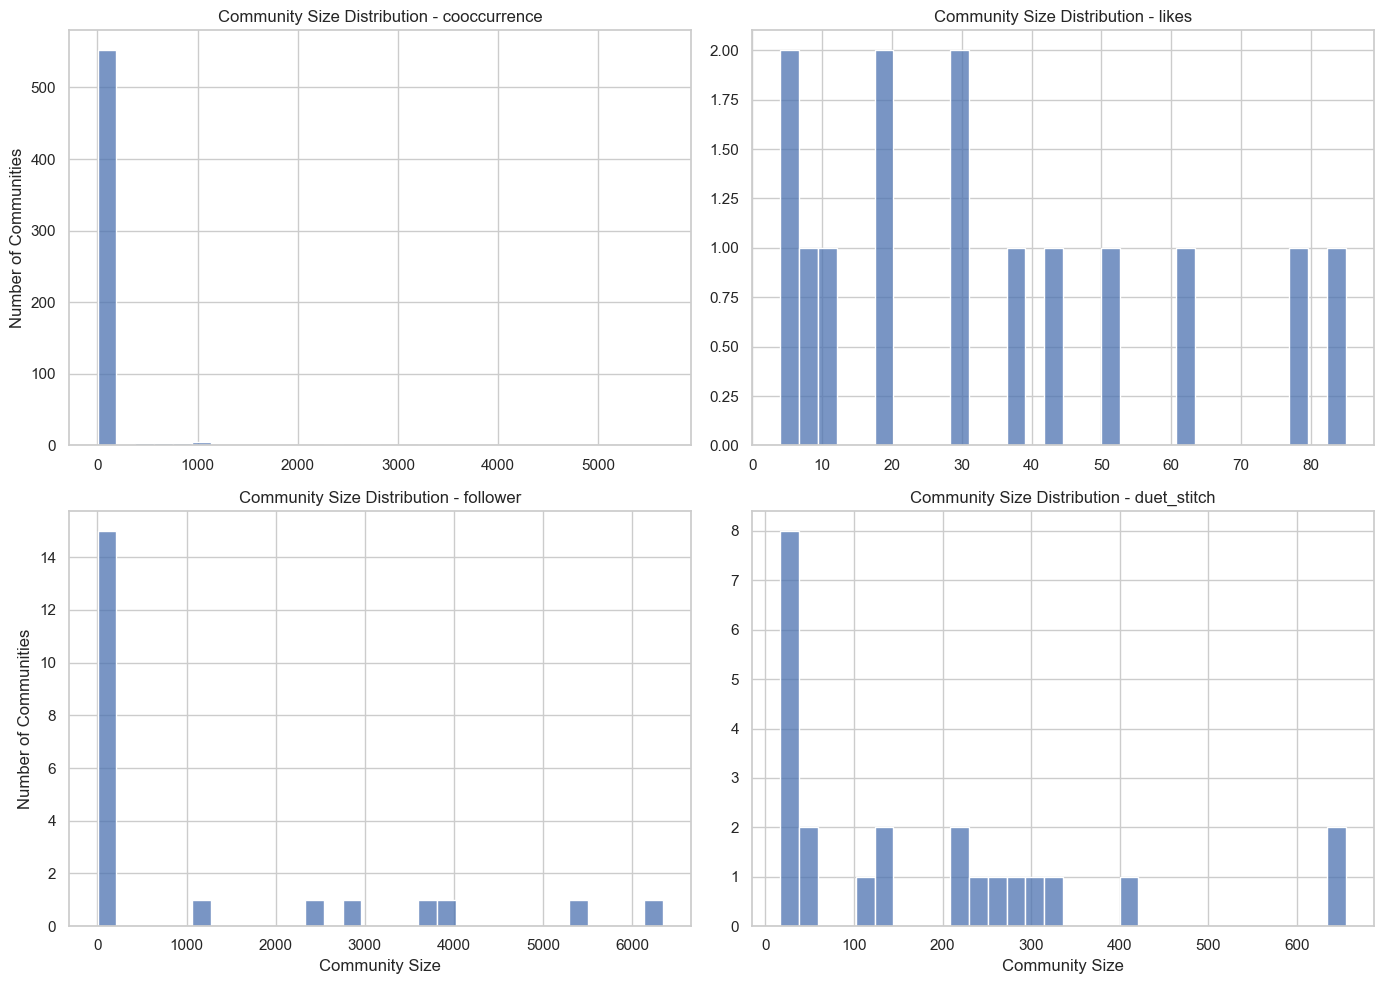

In [145]:
large_community_counts = {}

# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten for easier indexing

# Plot histograms
for i, (name, partition) in enumerate(communities.items()):
    community_sizes = [len(c) for c in partition]

    # Plot histogram
    sns.histplot(community_sizes, bins=30, kde=False, ax=axes[i])
    axes[i].set_title(f"Community Size Distribution - {name}")

    # X label only for bottom row
    if i >= 2:
        axes[i].set_xlabel("Community Size")
    else:
        axes[i].set_xlabel("")

    # Y label only for first column
    if i % 2 == 0:
        axes[i].set_ylabel("Number of Communities")
    else:
        axes[i].set_ylabel("")

    axes[i].legend().set_visible(False)  # Optional: hide empty legend
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [66]:
def filter_graph_by_existing_partition(ig_graph, partition, keep_ratio=0.8):
    # Step 1: Sort communities by size
    community_sizes = sorted([(i, len(comm)) for i, comm in enumerate(partition)], key=lambda x: x[1], reverse=True)
    total_nodes = sum(size for _, size in community_sizes)
    cutoff = keep_ratio * total_nodes

    # Step 2: Select communities to keep
    selected_communities = set()
    accum = 0
    for cid, size in community_sizes:
        if accum >= cutoff:
            break
        selected_communities.add(cid)
        accum += size

    # Step 3: Gather all node indices in selected communities
    nodes_to_keep = []
    for cid in selected_communities:
        nodes_to_keep.extend(partition[cid])

    # Step 4: Filter the graph
    filtered_graph = ig_graph.subgraph(nodes_to_keep)

    return filtered_graph, selected_communities  # return kept communities too

# Run filtering using existing partitions and print count
filtered_networks = {}
retained_communities_count = {}

for name, nx_graph in networks.items():
    print(f"Filtering network: {name}")
    ig_graph = nx_to_igraph(nx_graph)  # Re-create iGraph from NetworkX
    partition = communities[name]      # Already computed Leiden partition

    filtered_ig_graph, selected_communities = filter_graph_by_existing_partition(
        ig_graph, partition, keep_ratio=0.8
    )

    filtered_networks[name] = filtered_ig_graph
    retained_communities_count[name] = len(selected_communities)

    print(f"{name}: kept {len(selected_communities)} communities, {filtered_ig_graph.vcount()} nodes remaining")

Filtering network: cooccurrence
cooccurrence: kept 16 communities, 32234 nodes remaining
Filtering network: likes
likes: kept 7 communities, 388 nodes remaining
Filtering network: follower
follower: kept 5 communities, 22149 nodes remaining
Filtering network: duet_stitch
duet_stitch: kept 10 communities, 3417 nodes remaining


/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/1063002740.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)
/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/1063002740.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)
/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/1063002740.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend().set_visible(False)
/var/folders/c1/phfhvpvx33z0wfs1rywcsz140000gn/T/ipykernel_9129/1063002740.py:34: UserWarning: No artists with labels found to put

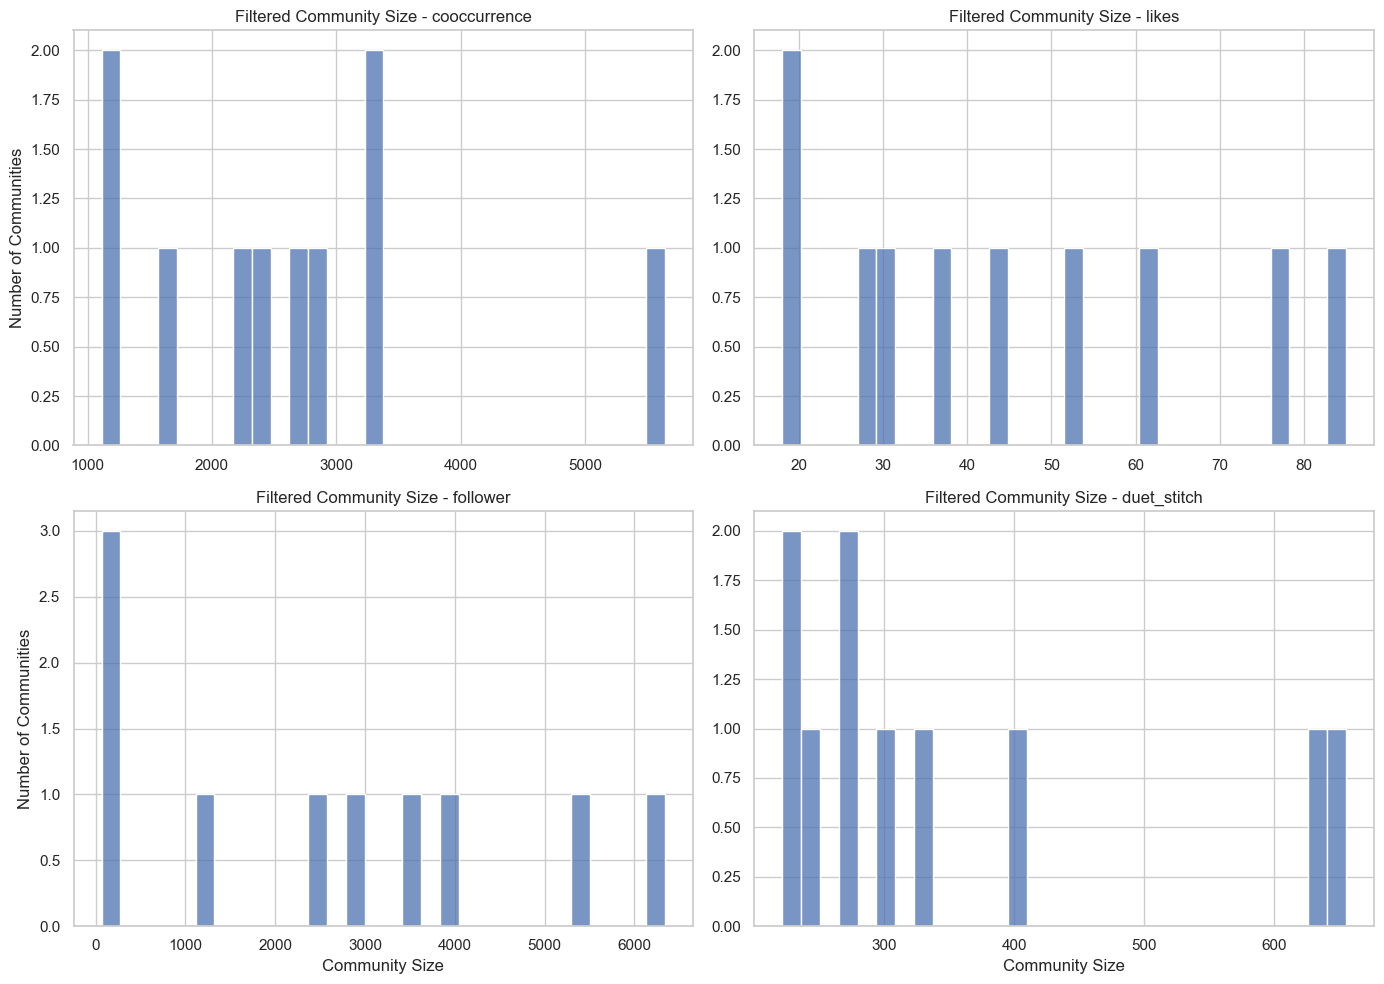

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, ig_graph) in enumerate(filtered_networks.items()):
    selected_ids = retained_communities_count[name]
    original_partition = communities[name]

    # Extract communities that were retained
    filtered_partition = [original_partition[cid] for cid in range(len(original_partition)) if cid in selected_communities]

    # Compute community sizes
    community_sizes = [len(comm) for comm in filtered_partition]

    # Plot histogram
    sns.histplot(community_sizes, bins=30, kde=False, ax=axes[i])
    axes[i].set_title(f"Filtered Community Size - {name}")

    # X label only on bottom row
    if i >= 2:
        axes[i].set_xlabel("Community Size")
    else:
        axes[i].set_xlabel("")

    # Y label only on left column
    if i % 2 == 0:
        axes[i].set_ylabel("Number of Communities")
    else:
        axes[i].set_ylabel("")

    axes[i].legend().set_visible(False)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


create sorted list ofg community size - top 80% then 20 top of 
do for all networks but then say its not needed

Identify the top 80% largest communities in the likes network.
Create a mapping from hashtags to their community using defaultdict.
Generate two types of hashtag pairs:
within-community edges
across-community edges
Compute cosine similarity between the hashtags in each pair (assuming you have vector representations of hashtags).

In [ ]:
# Dictionary to store hashtag → community_id mappings for each network
hashtag_to_community_map = {}

for name, nx_graph in networks.items():
    print(f"Processing mapping for: {name}")
    ig_graph = nx_to_igraph(nx_graph)
    partition = communities[name]

    # Step 1: Compute top 80% retained community IDs again
    community_sizes = sorted([(i, len(comm)) for i, comm in enumerate(partition)], key=lambda x: x[1], reverse=True)
    total_nodes = sum(size for _, size in community_sizes)
    cutoff = 0.8 * total_nodes

    selected_communities = set()
    accum = 0
    for cid, size in community_sizes:
        if accum >= cutoff:
            break
        selected_communities.add(cid)
        accum += size

    # Step 2: Build hashtag → community_id map
    hashtag_to_comm = defaultdict(lambda: -1)  # default -1 for unassigned

    for cid in selected_communities:
        for idx in partition[cid]:
            hashtag = ig_graph.vs[idx]["name"]
            hashtag_to_comm[hashtag] = cid

    hashtag_to_community_map[name] = hashtag_to_comm

    print(f"{name}: Mapped {len(hashtag_to_comm)} hashtags to top communities.")


Processing mapping for: cooccurrence
cooccurrence: Mapped 32234 hashtags to top communities.
Processing mapping for: likes
likes: Mapped 388 hashtags to top communities.
Processing mapping for: follower
follower: Mapped 22149 hashtags to top communities.
Processing mapping for: duet_stitch
duet_stitch: Mapped 3417 hashtags to top communities.


In [68]:
hashtag_to_community_map

{'cooccurrence': defaultdict(<function __main__.<lambda>()>,
             {'art': 0,
              'style': 0,
              'green': 0,
              'solar': 0,
              'fashionillustrator': 0,
              'fashionillustration': 0,
              'fashiondesign': 0,
              'sunnies': 0,
              'sunglasses': 0,
              'consciousliving': 0,
              'ditchsingleuse': 0,
              'neutralhomedecor': 0,
              'unpapertowels': 0,
              'homeandsoul': 0,
              'furniture': 0,
              'ethical': 0,
              'homeandsouldubai': 0,
              'mompreneur': 0,
              'dubailiving': 0,
              'dubaismallbusiness': 0,
              'greenliving': 0,
              'decor': 0,
              'madeinoregon': 0,
              'worldnewstonight': 0,
              'zerowaste': 0,
              'reducereuse': 0,
              'boho': 0,
              'lowwaste': 0,
              'homedesign': 0,
              'thin

In [ ]:
# Set random seed for reproducibility (optional)
random.seed(42)

within_community_edges = {}

for name, ig_graph in filtered_networks.items():
    print(f"Processing within-community edges for: {name}")

    hashtag_to_comm = hashtag_to_community_map[name]
    comm_edges = defaultdict(list)

    for edge in ig_graph.es:
        source = ig_graph.vs[edge.source]["name"]
        target = ig_graph.vs[edge.target]["name"]

        c_source = hashtag_to_comm[source]
        c_target = hashtag_to_comm[target]

        if c_source == c_target and c_source != -1:
            comm_edges[c_source].append((source, target))

    # Limit each community's edge list to 500 pairs max
    for cid in comm_edges:
        if len(comm_edges[cid]) > 500:
            comm_edges[cid] = random.sample(comm_edges[cid], 500)

    within_community_edges[name] = comm_edges
    print(f"{name}: limited to 500 edges per community (total communities: {len(comm_edges)})")


Processing within-community edges for: cooccurrence
cooccurrence: limited to 500 edges per community (total communities: 16)
Processing within-community edges for: likes
likes: limited to 500 edges per community (total communities: 7)
Processing within-community edges for: follower
follower: limited to 500 edges per community (total communities: 5)
Processing within-community edges for: duet_stitch
duet_stitch: limited to 500 edges per community (total communities: 10)


In [82]:
within_community_edges

{'cooccurrence': defaultdict(list,
             {3: [('positivevibes', 'repent'),
               ('motivation', 'meditate'),
               ('faith', 'guidance'),
               ('positive', 'roots'),
               ('atlantis', 'jupiter'),
               ('support', 'learn'),
               ('self', 'soul'),
               ('dontgiveup', 'highesttimeline'),
               ('witches', 'babywitch'),
               ('peace', 'psychic'),
               ('motivation', 'save'),
               ('selflove', 'development'),
               ('macro', 'palladian'),
               ('vibration', 'spells'),
               ('mrbeast', 'caring'),
               ('motivation', 'abundance'),
               ('awakening', 'lawofattraction'),
               ('witchyvibes', 'scared'),
               ('thoughts', 'spiritualtiktok'),
               ('ase', 'trusttheprocess'),
               ('vibes', 'spreadlove'),
               ('life', 'christiantok'),
               ('gains', 'lovemylife'),
              

In [ ]:
# Create directory to store the edge lists
output_dir = "/Users/juliabijak/github/Bachelor/analysis/within_community_edge_lists"
os.makedirs(output_dir, exist_ok=True)

# Save each network's edge list
for name, comm_edges in within_community_edges.items():
    output_path = os.path.join(output_dir, f"{name}_within_edges.pkl")
    with open(output_path, "wb") as f:
        pickle.dump(comm_edges, f)
    print(f"Saved within-community edges for '{name}' to {output_path}")




Saved within-community edges for 'cooccurrence' to /Users/juliabijak/github/Bachelor/analysis/edhe_list/within_community_edge_lists/cooccurrence_within_edges.pkl
Saved within-community edges for 'likes' to /Users/juliabijak/github/Bachelor/analysis/edhe_list/within_community_edge_lists/likes_within_edges.pkl
Saved within-community edges for 'follower' to /Users/juliabijak/github/Bachelor/analysis/edhe_list/within_community_edge_lists/follower_within_edges.pkl
Saved within-community edges for 'duet_stitch' to /Users/juliabijak/github/Bachelor/analysis/edhe_list/within_community_edge_lists/duet_stitch_within_edges.pkl


In [ ]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load saved within-community edge lists
input_dir = "within_community_edge_lists"
within_community_edges = {}

for fname in os.listdir(input_dir):
    if fname.endswith("_within_edges.pkl"):
        network_name = fname.replace("_within_edges.pkl", "")
        with open(os.path.join(input_dir, fname), "rb") as f:
            within_community_edges[network_name] = pickle.load(f)

# Compute cosine similarities
network_similarities = {}

for net_name, comm_edges in within_community_edges.items():
    print(f"\nProcessing: {net_name}")
    network_similarities[net_name] = {}

    for comm_id, pairs in comm_edges.items():
        # Flatten and get unique hashtags
        unique_tags = list(set([tag for pair in pairs for tag in pair]))
        if not unique_tags:
            continue

        embeddings = model.encode(unique_tags, convert_to_tensor=True)
        tag_to_vec = {tag: vec for tag, vec in zip(unique_tags, embeddings)}

        # Compute cosine similarity for each pair
        similarities = []
        for a, b in pairs:
            sim = cosine_similarity(
                tag_to_vec[a].unsqueeze(0).cpu().numpy(),
                tag_to_vec[b].unsqueeze(0).cpu().numpy()
            )[0][0]
            similarities.append(sim)

        network_similarities[net_name][comm_id] = similarities




Processing: follower

Processing: duet_stitch

Processing: cooccurrence

Processing: likes


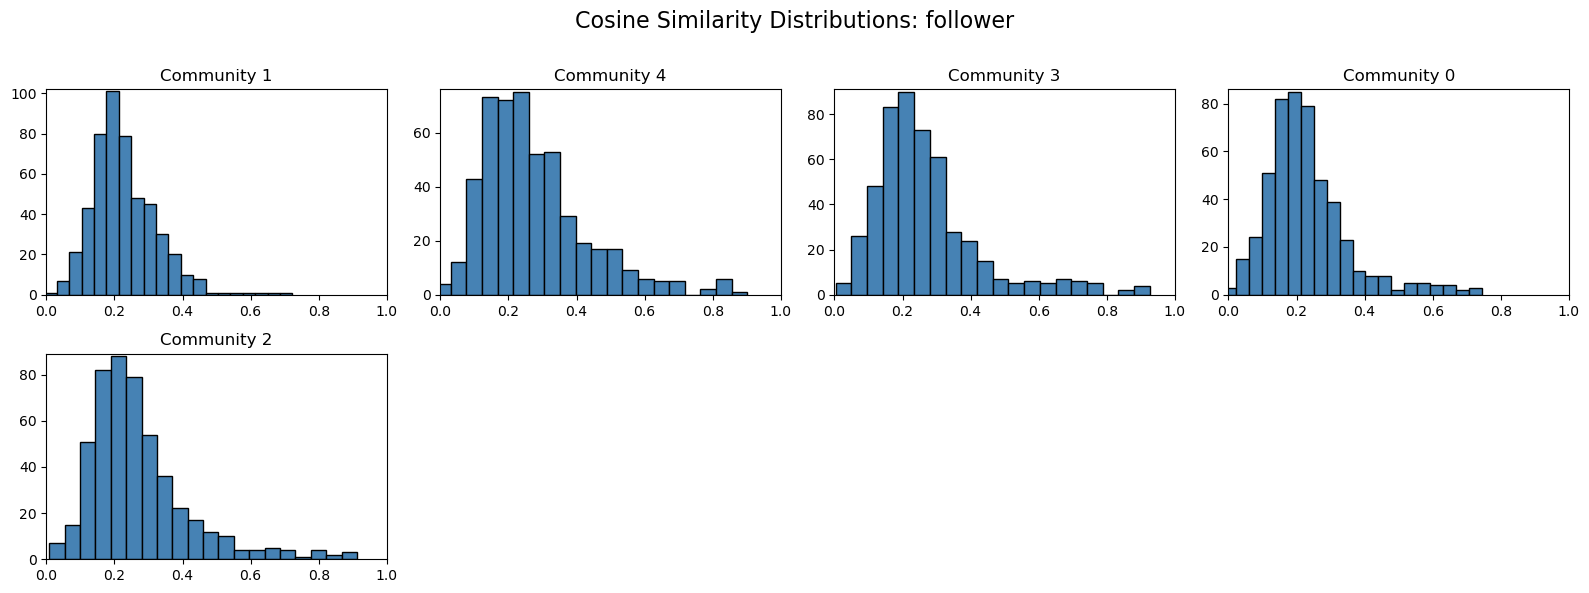

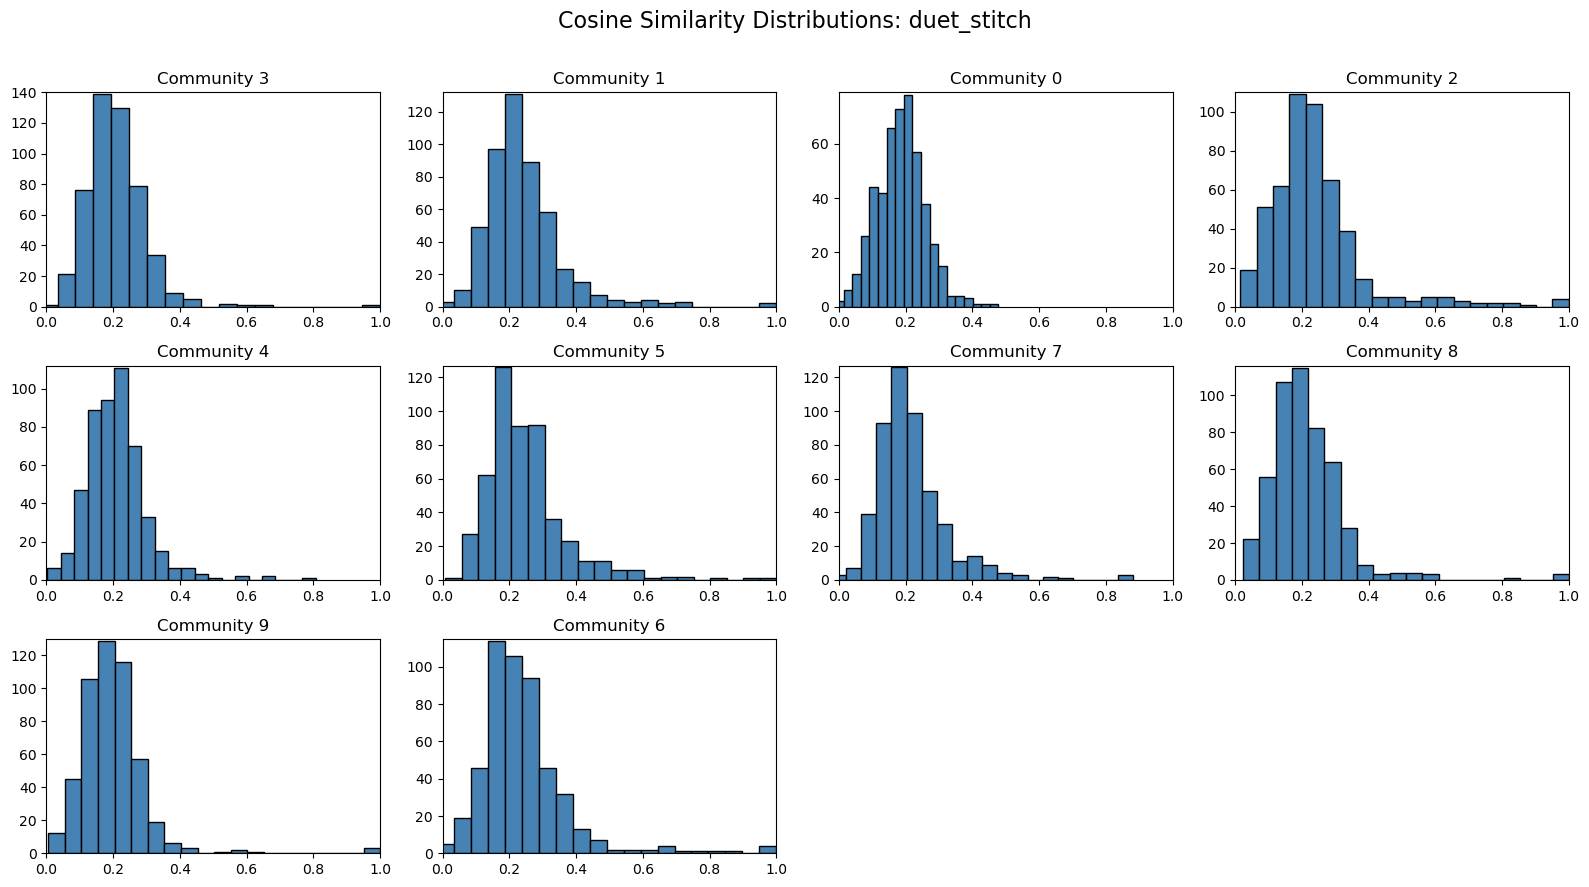

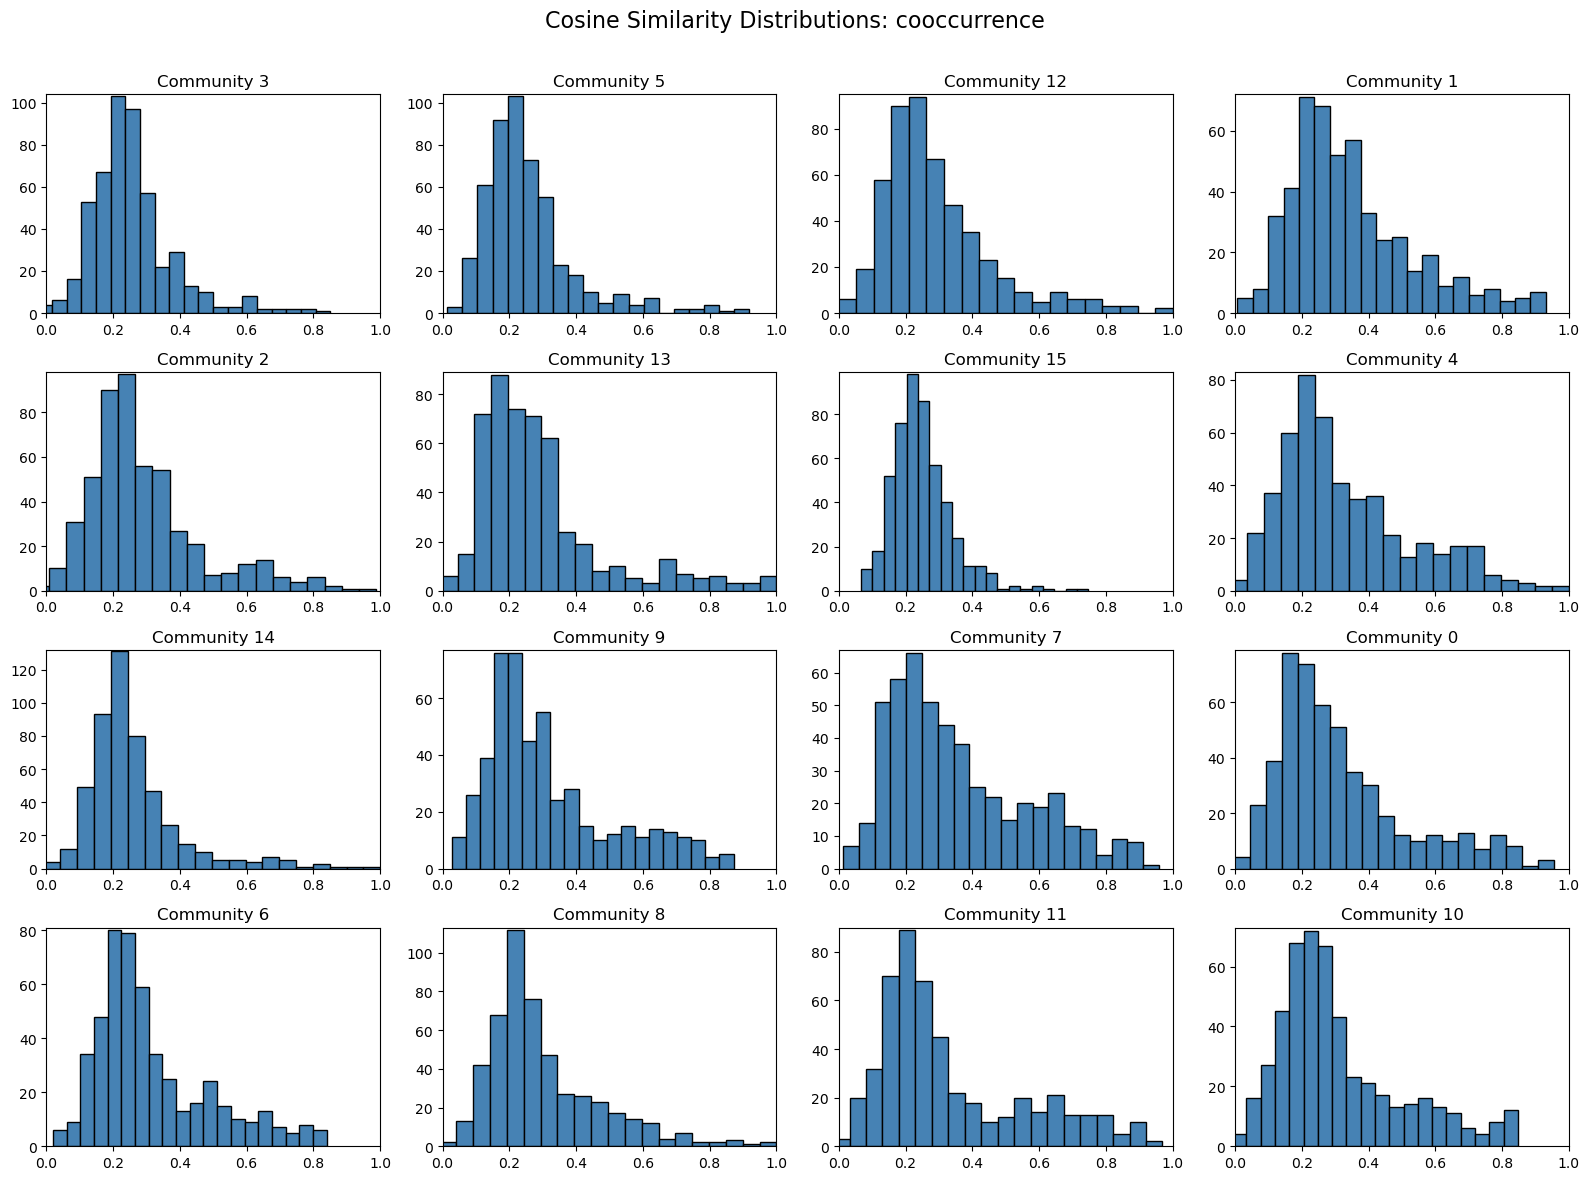

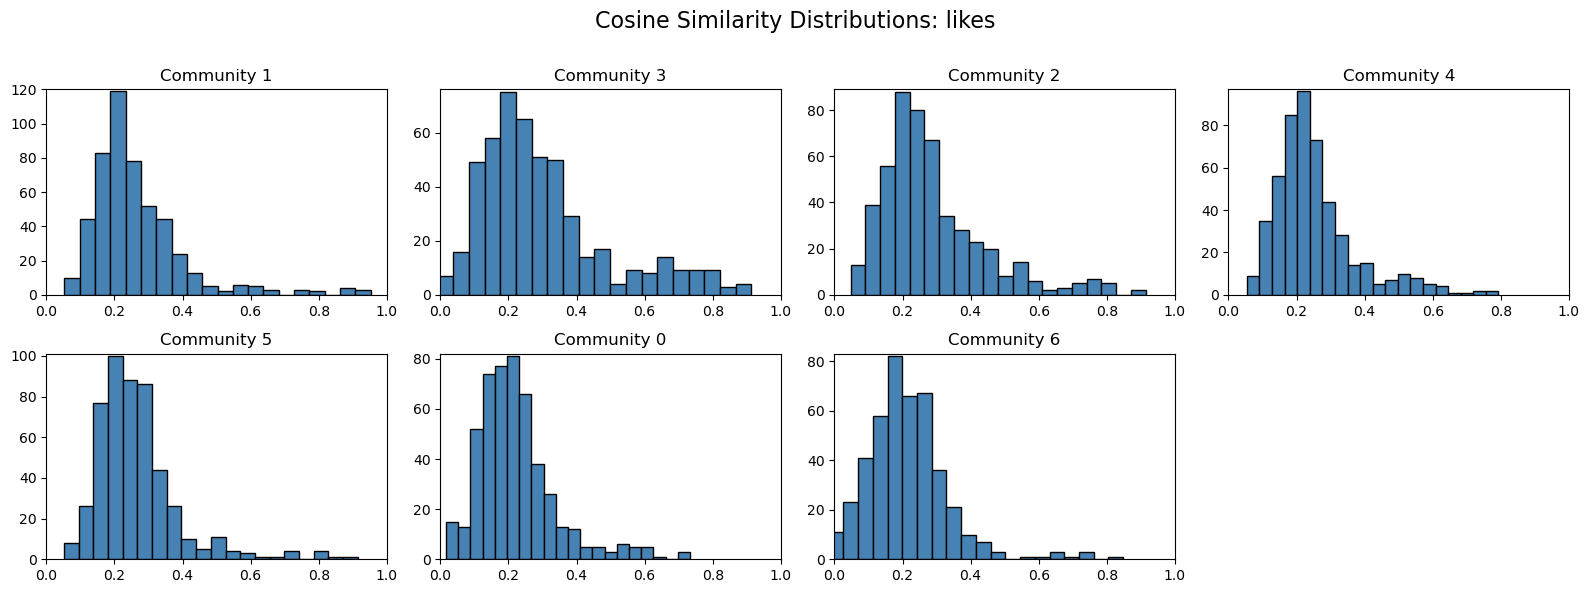

In [ ]:
for net_name, comm_sims in network_similarities.items():
    num_comms = len(comm_sims)
    cols = 4
    rows = math.ceil(num_comms / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    for idx, (comm_id, sims) in enumerate(comm_sims.items()):
        ax = axes[idx]
        ax.hist(sims, bins=20, color='steelblue', edgecolor='black')
        ax.set_title(f"Community {comm_id}")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max(np.histogram(sims, bins=20)[0]) + 1)

    # empty plots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Cosine Similarity Distributions: {net_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


## Average Community Cosine Similarity per Network

In [95]:
average_cosine_similarity = {}

for net_name, comm_sims in network_similarities.items():
    all_sims = []
    for sims in comm_sims.values():
        all_sims.extend(sims)

    if all_sims:
        avg_sim = sum(all_sims) / len(all_sims)
    else:
        avg_sim = float('nan')  # Handle empty case safely

    average_cosine_similarity[net_name] = avg_sim
    print(f"{net_name}: Average Cosine Similarity = {avg_sim:.4f}")


follower: Average Cosine Similarity = 0.2542
duet_stitch: Average Cosine Similarity = 0.2197
cooccurrence: Average Cosine Similarity = 0.3006
likes: Average Cosine Similarity = 0.2591


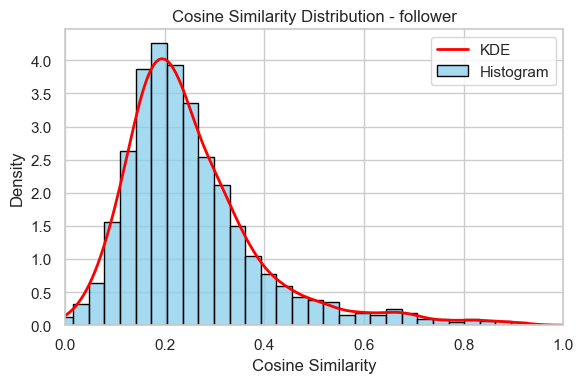

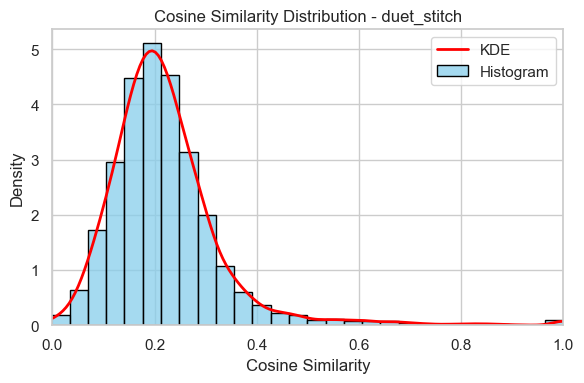

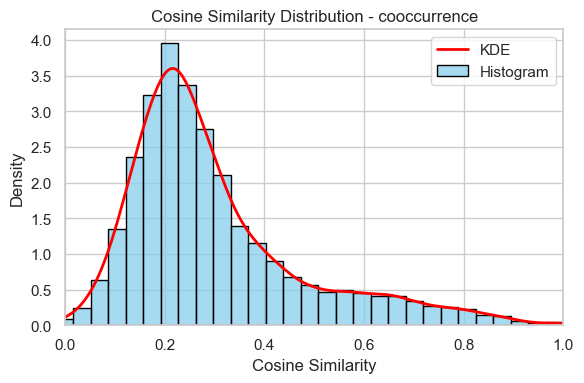

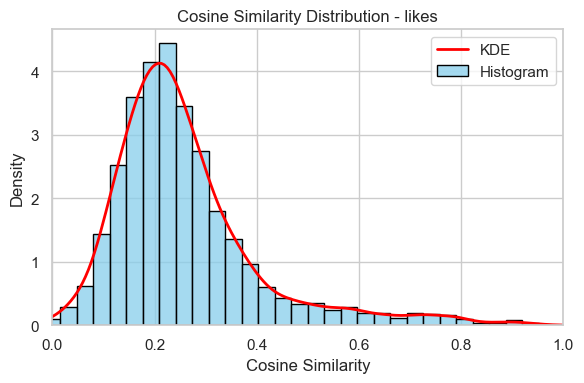

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for net_name, comm_sims in network_similarities.items():
    all_sims = []
    for sims in comm_sims.values():
        all_sims.extend(sims)

    if not all_sims:
        print(f"{net_name}: No similarity scores to plot.")
        continue

    plt.figure(figsize=(6, 4))

    # Histogram with density
    sns.histplot(all_sims, bins=30, kde=False, color='skyblue', edgecolor='black', stat='density', label='Histogram')

    # Red KDE line
    sns.kdeplot(all_sims, color='red', linewidth=2, label='KDE')

    plt.title(f"Cosine Similarity Distribution - {net_name}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()



## Cosine Similarities for Across-Community Edges

In [102]:
from collections import defaultdict
import random

random.seed(42)  # for reproducibility

across_community_edges = {}

for net_name, ig_graph in filtered_networks.items():
    print(f"\nProcessing across-community edges for: {net_name}")

    hashtag_to_comm = hashtag_to_community_map[net_name]
    cross_edges = []

    for edge in ig_graph.es:
        u = ig_graph.vs[edge.source]["name"]
        v = ig_graph.vs[edge.target]["name"]

        c_u = hashtag_to_comm.get(u, -1)
        c_v = hashtag_to_comm.get(v, -1)

        # Skip if any hashtag is not in a community or in same community
        if c_u == -1 or c_v == -1 or c_u == c_v:
            continue

        cross_edges.append((u, v))

    # Randomly sample up to 1000 pairs
    if len(cross_edges) > 2000:
        cross_edges = random.sample(cross_edges, 2000)

    across_community_edges[net_name] = cross_edges
    print(f"{net_name}: Collected {len(cross_edges)} across-community edges")



Processing across-community edges for: cooccurrence
cooccurrence: Collected 2000 across-community edges

Processing across-community edges for: likes
likes: Collected 136 across-community edges

Processing across-community edges for: follower
follower: Collected 2000 across-community edges

Processing across-community edges for: duet_stitch
duet_stitch: Collected 2000 across-community edges


In [103]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the model (if not already loaded)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Dictionary to store cosine similarities
across_community_similarities = {}

for net_name, edge_list in across_community_edges.items():
    print(f"\nComputing similarities for across-community edges: {net_name}")

    # Flatten list of pairs and get unique hashtags
    unique_tags = list(set([tag for pair in edge_list for tag in pair]))
    embeddings = model.encode(unique_tags, convert_to_tensor=True)
    tag_to_vec = {tag: vec for tag, vec in zip(unique_tags, embeddings)}

    sims = []
    for a, b in edge_list:
        sim = cosine_similarity(
            tag_to_vec[a].unsqueeze(0).cpu().numpy(),
            tag_to_vec[b].unsqueeze(0).cpu().numpy()
        )[0][0]
        sims.append(sim)

    across_community_similarities[net_name] = sims



Computing similarities for across-community edges: cooccurrence

Computing similarities for across-community edges: likes

Computing similarities for across-community edges: follower

Computing similarities for across-community edges: duet_stitch


In [149]:
for net_name, edge_list in across_community_edges.items():
    print(f"\nComputing similarities for across-community edges: {net_name}")

    # Flatten list of pairs and get unique hashtags
    unique_tags = list(set([tag for pair in edge_list for tag in pair]))
    embeddings = model.encode(unique_tags, convert_to_tensor=True)
    tag_to_vec = {tag: vec for tag, vec in zip(unique_tags, embeddings)}

    sims = []
    for a, b in edge_list:
        sim = cosine_similarity(
            tag_to_vec[a].unsqueeze(0).cpu().numpy(),
            tag_to_vec[b].unsqueeze(0).cpu().numpy()
        )[0][0]
        sims.append(sim)

    across_community_similarities[net_name] = sims

    # Compute the average cosine similarity for the current network
    avg_similarity = np.mean(sims)
    print(f"Average Cosine Similarity for {net_name}: {avg_similarity:.4f}")


Computing similarities for across-community edges: cooccurrence
Average Cosine Similarity for cooccurrence: 0.2692

Computing similarities for across-community edges: likes
Average Cosine Similarity for likes: 0.2618

Computing similarities for across-community edges: follower
Average Cosine Similarity for follower: 0.2090

Computing similarities for across-community edges: duet_stitch
Average Cosine Similarity for duet_stitch: 0.2176


## Visualized Distribution with Histogram + Red KDE

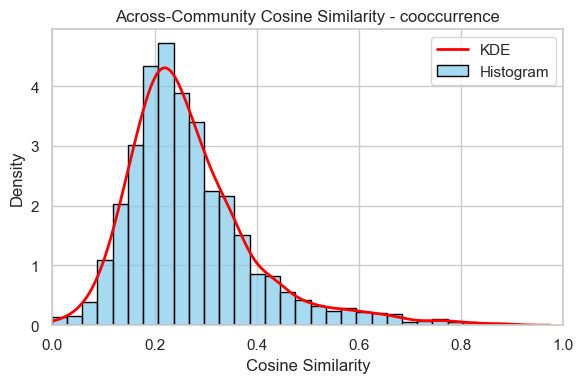

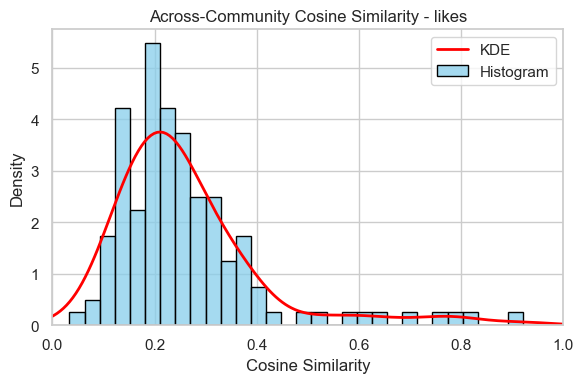

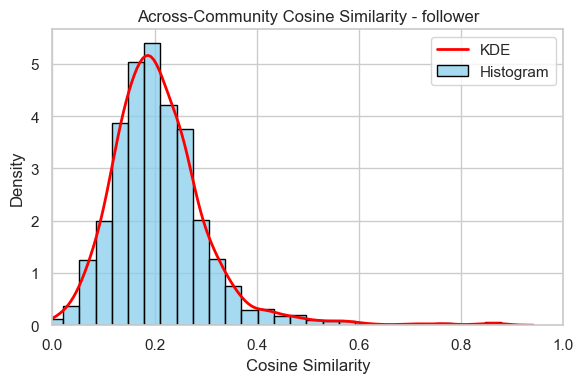

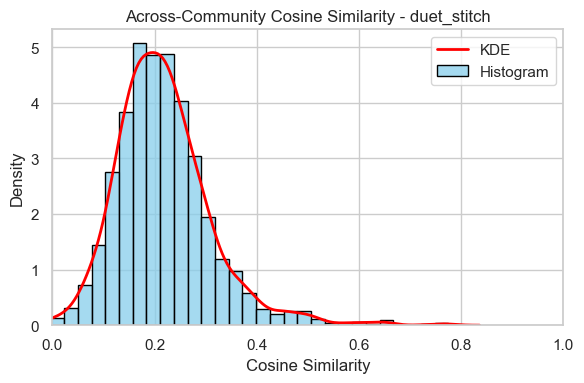

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for net_name, sims in across_community_similarities.items():
    if not sims:
        print(f"{net_name}: No similarity scores to plot.")
        continue

    plt.figure(figsize=(6, 4))

    # Histogram and KDE
    sns.histplot(sims, bins=30, kde=False, color='skyblue', edgecolor='black', stat='density', label='Histogram')
    sns.kdeplot(sims, color='red', linewidth=2, label='KDE')

    plt.title(f"Across-Community Cosine Similarity - {net_name}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Ridge plot 

In [106]:
import pandas as pd

# Prepare combined DataFrame
data_rows = []

for net_name in network_similarities:
    within = network_similarities[net_name]
    across = across_community_similarities.get(net_name, {})

    # Flatten each community's similarity list into rows
    for sims in within.values():
        for sim in sims:
            data_rows.append({'Network': net_name, 'Similarity': sim, 'Type': 'Within'})

    for sim in across:
        data_rows.append({'Network': net_name, 'Similarity': sim, 'Type': 'Across'})

# Convert to DataFrame
df = pd.DataFrame(data_rows)


In [108]:
# Split the combined dataframe into two: one for within and one for across
df_within = df[df['Type'] == 'Within'].copy()
df_across = df[df['Type'] == 'Across'].copy()

# Set a clearer label (just the network name)
df_within['Label'] = df_within['Network']
df_across['Label'] = df_across['Network']


Text(0.5, 62.583333333333314, 'Cosine Similarity')

<Figure size 1000x600 with 0 Axes>

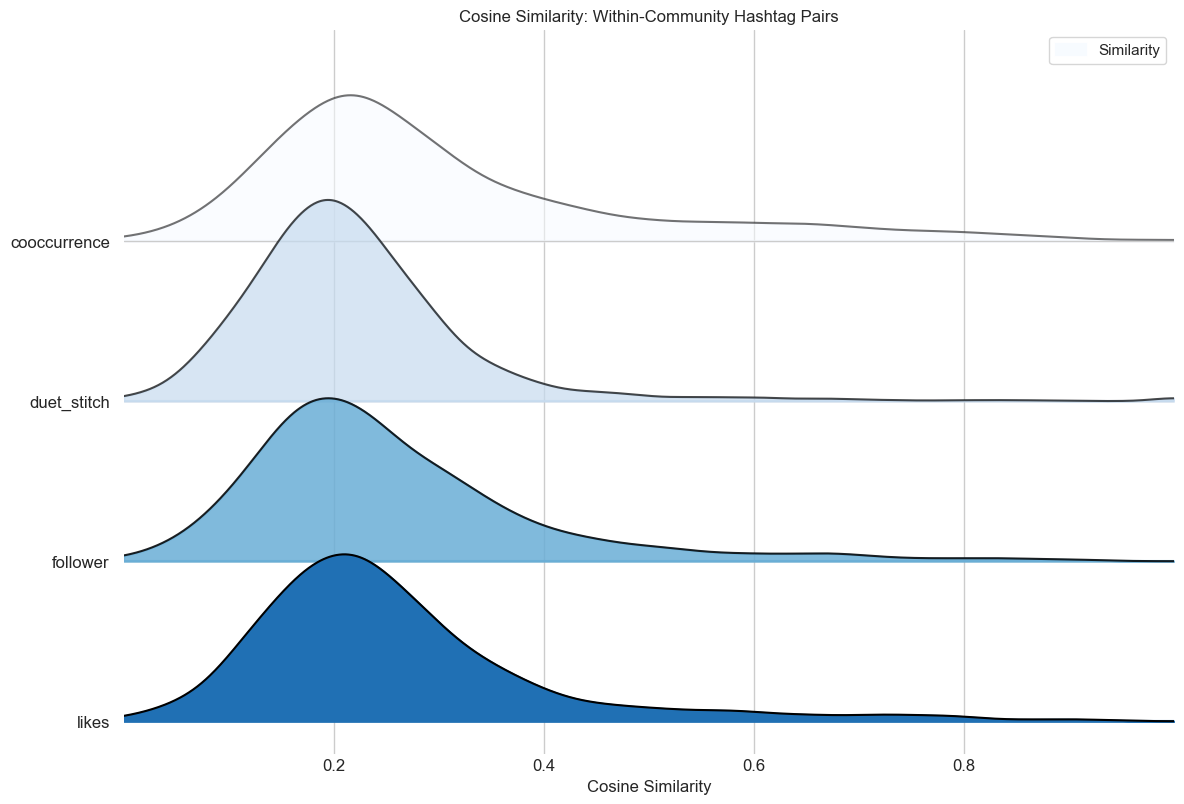

In [113]:
import joypy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
fig, axes = joypy.joyplot(
    df_within,
    by='Label',
    column='Similarity',
    figsize=(12, 8),
    kind='kde',
    linewidth=1.5,
    fade=True,
    colormap=plt.cm.Blues,
    overlap=1,
    x_range=[0, 1],
    title="Cosine Similarity: Within-Community Hashtag Pairs",
    grid=True,
    linecolor="black",
    hist=False,
    legend=True
)

# Add x-axis label
plt.xlabel("Cosine Similarity")




Text(0.5, 62.583333333333314, 'Cosine Similarity')

<Figure size 1000x600 with 0 Axes>

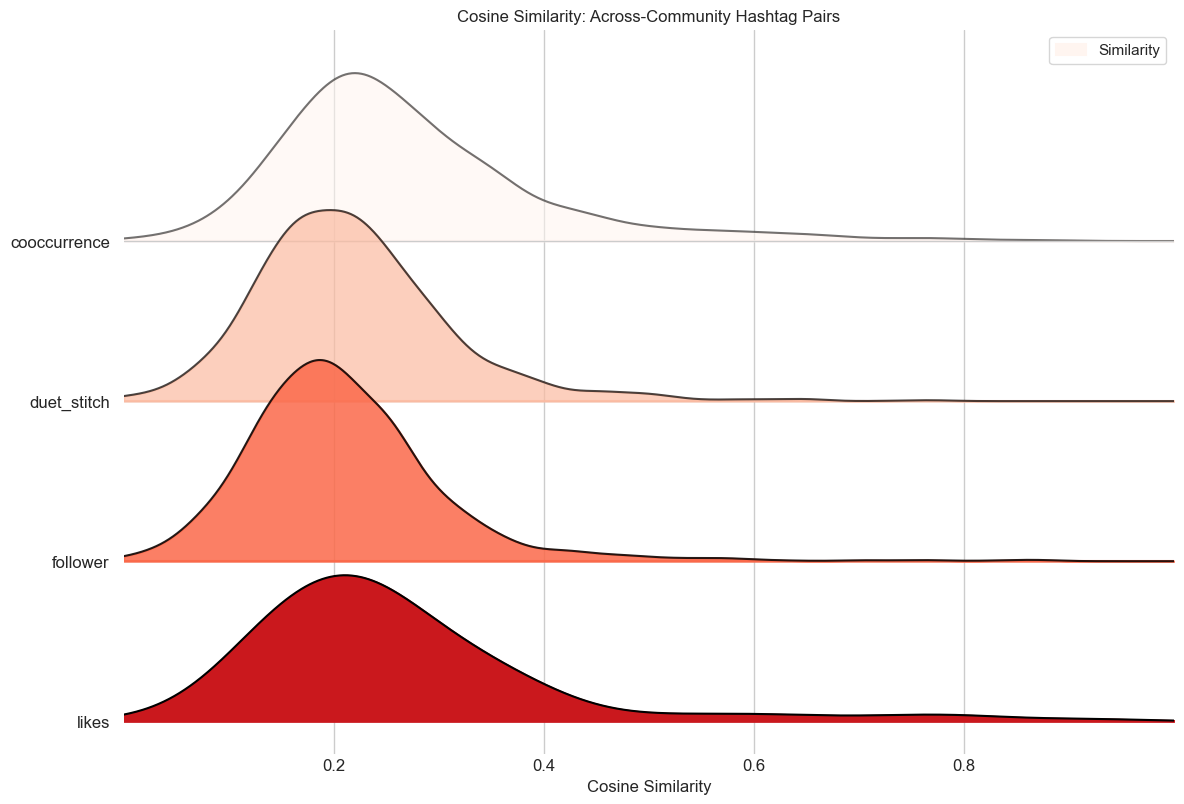

In [114]:
# Ridgeline Plot for Across-Community Pairs 
plt.figure(figsize=(10, 6))
fig, axes = joypy.joyplot(
    df_across,
    by='Label',
    column='Similarity',
    figsize=(12, 8),
    kind='kde',
    linewidth=1.5,
    fade=True,
    colormap=plt.cm.Reds,
    overlap=1,
    x_range=[0, 1],
    title="Cosine Similarity: Across-Community Hashtag Pairs",
    grid=True,
    linecolor="black",
    hist=False,
    legend=True
)

# Add x-axis label
plt.xlabel("Cosine Similarity")



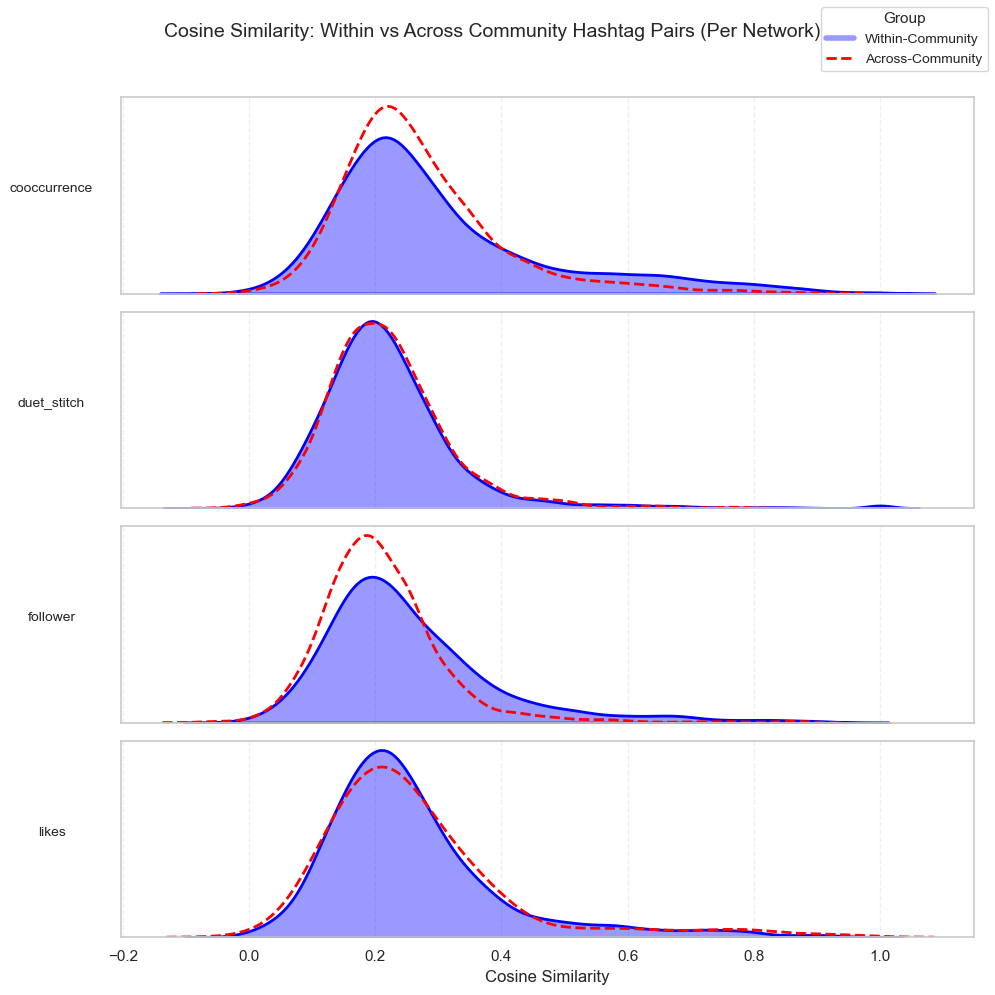

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure Label categories are consistent in both DataFrames
common_labels = set(df_within['Label']).intersection(set(df_across['Label']))
df_within = df_within[df_within['Label'].isin(common_labels)]
df_across = df_across[df_across['Label'].isin(common_labels)]

# Sort labels for consistent order
labels = sorted(common_labels)

# Setup the plot
n = len(labels)
fig, axes = plt.subplots(n, 1, figsize=(10, 2.5 * n), sharex=True)

# Plot per label
for i, label in enumerate(labels):
    ax = axes[i]

    # Within-community (Blue)
    sns.kdeplot(
        data=df_within[df_within['Label'] == label],
        x='Similarity',
        ax=ax,
        fill=True,
        color='blue',
        alpha=0.4,
        linewidth=2
    )

    # Across-community (Red, Dashed)
    sns.kdeplot(
        data=df_across[df_across['Label'] == label],
        x='Similarity',
        ax=ax,
        fill=False,
        color='red',
        linestyle='--',
        linewidth=2
    )

    ax.set_ylabel(label, rotation=0, labelpad=50, fontsize=10)
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.3)
    if i != n - 1:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Cosine Similarity", fontsize=12)

# Create a single legend
handles = [
    plt.Line2D([0], [0], color='blue', lw=4, alpha=0.4, label='Within-Community'),
    plt.Line2D([0], [0], color='red', lw=2, linestyle='--', label='Across-Community')
]
fig.legend(handles=handles, loc='upper right', fontsize=10, title="Group", title_fontsize=11)

# Title and layout
fig.suptitle("Cosine Similarity: Within vs Across Community Hashtag Pairs (Per Network)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
